In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [2]:
df = pd.read_csv('https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
df.shape

(92016, 5)

In [4]:
df.columns

Index(['FullDate', 'Tmax', 'SysLoad', 'GasPrice', 'ElecPrice'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [6]:
df.isna().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [7]:
df.corr()

,Tmax,SysLoad,GasPrice,ElecPrice
Tmax,1.000000,-0.009796,0.030173,0.002126
SysLoad,-0.009796,1.000000,-0.214574,0.138690
GasPrice,0.030173,-0.214574,1.000000,0.157768
ElecPrice,0.002126,0.138690,0.157768,1.000000


In [8]:
# converting to datetime object
df['FullDate']= pd.to_datetime(df['FullDate'])

In [9]:
df.set_index('FullDate', inplace = True) 

In [10]:
df_daily = df.resample('D').sum()

In [11]:
df_daily.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [12]:
df_daily.shape

(3834, 4)

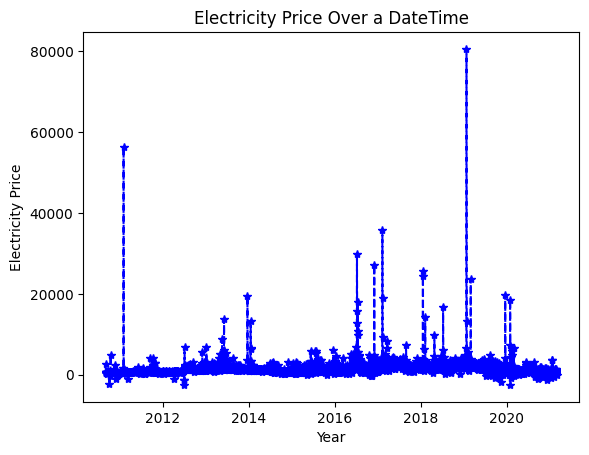

In [13]:
#Question:11, plotting electricity price over dATEtime
plt.plot(df_daily.index, df_daily.ElecPrice, '--', marker='*',color='blue')
plt.xlabel('Year')
plt.ylabel('Electricity Price')
plt.title('Electricity Price Over a DateTime')
plt.show()

In [14]:
#Question:12,  P-value of the SysLoad and GasPrice of the resampled Data set
pval_sys = adfuller(df_daily['SysLoad']) 
pval_gas = adfuller(df_daily['GasPrice']) 
round(pval_sys[1], 6), round(pval_gas[1], 6)

(0.004254, 0.045027)

In [15]:
#Question:13, what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set
Crv_Elecprice = adfuller(df_daily['ElecPrice'])
round(pval_gas[4]['10%'], 4), round(Crv_Elecprice[4]['5%'], 4)

(-2.5672, -2.8623)

In [16]:
# Splitting the daily sampled rate into train and test 
train_data = df_daily.iloc[:2757,:]
test_data = df_daily.iloc[2757:,:]
train_data.shape 

(2757, 4)

In [17]:
test_data.shape

(1077, 4)

In [18]:
# Reset the index
train_data.reset_index(inplace = True)
train_data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [19]:
# we have to rename the FullDate and ElecPrice columns as follows
df_train = train_data.iloc[:,[0,-1]]
df_train = df_train.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
df_train.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [20]:
# Reset the index
test_data.reset_index(inplace = True)
test_data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2018-03-20,540.0,7696.91130,201.5880,1833.00
1,2018-03-21,571.2,4658.05865,203.2560,1730.49
2,2018-03-22,722.4,19161.78525,203.2560,2260.55
3,2018-03-23,811.2,18090.43435,198.6456,2138.76
4,2018-03-24,832.8,3763.53865,180.2160,1721.70


In [21]:
# we have to rename the FullDate and ElecPrice columns as follows
df_test = test_data.iloc[:,[0,-1]]
df_test = df_test.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
df_test.head()

,ds,y
0,2018-03-20,1833.00
1,2018-03-21,1730.49
2,2018-03-22,2260.55
3,2018-03-23,2138.76
4,2018-03-24,1721.70


In [22]:
# creating a Model with Prophet
model = Prophet()
model.fit(df_train)
forecast = model.predict(df_test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplpzxd83_/5qjix907.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplpzxd83_/lhwcq9h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26803', 'data', 'file=/tmp/tmplpzxd83_/5qjix907.json', 'init=/tmp/tmplpzxd83_/lhwcq9h5.json', 'output', 'file=/tmp/tmplpzxd83_/prophet_modelhrudwp0d/prophet_model-20230401192112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,2687.807715,388.289906,5034.240684,2687.807715,2687.807715,-155.281939,-155.281939,-155.281939,9.737752,9.737752,9.737752,-165.019691,-165.019691,-165.019691,0.0,0.0,0.0,2532.525776
1,2018-03-21,2688.609367,381.301707,4982.881889,2688.609367,2688.609367,-2.749381,-2.749381,-2.749381,159.365206,159.365206,159.365206,-162.114587,-162.114587,-162.114587,0.0,0.0,0.0,2685.859986


In [24]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [25]:
# MAPE function
def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

In [26]:
#Question:14, Evaluating the results of your time series model on the test set
MAPE = Metric(df_test['y'],forecast['yhat'])
round(MAPE,2)

546.46

In [27]:
#Question:15, What is the RMSE in 2 decimal places
RMSE = np.sqrt(mean_squared_error(df_test['y'],forecast['yhat']))
round(RMSE,2)

3211.82

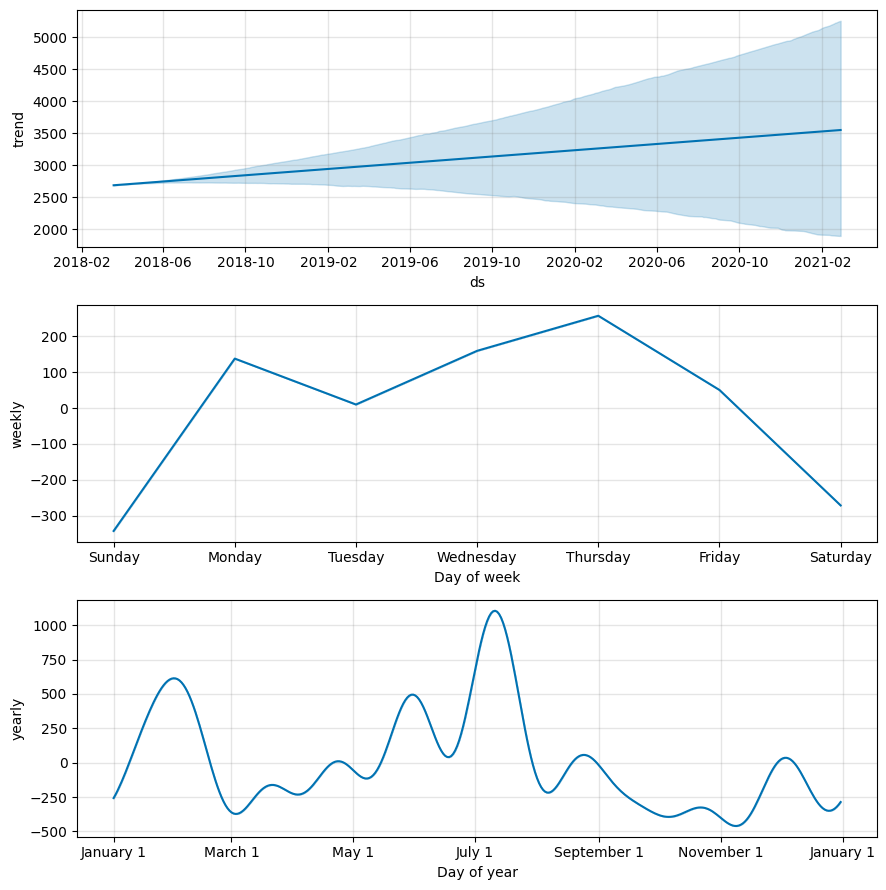

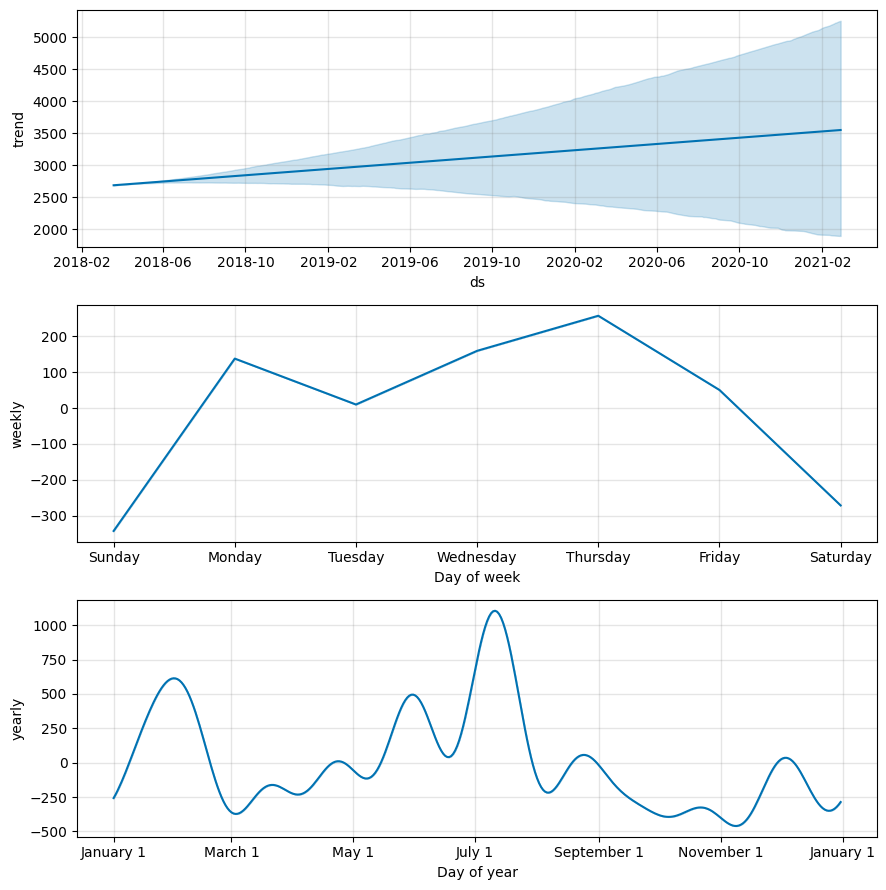

In [28]:
#Question:16, plot the components from the forecasted model, what month of the yearly seasonality has the highest value?
model.plot_components(forecast)

In [29]:
# Multivariate Time Series Model

In [30]:
# Reset the index
df_daily.reset_index(inplace=True)

In [31]:
# Renaming the columns 
df2 = df_daily.rename(columns = {'FullDate':'ds','Tmax':'add2',
                                           'SysLoad':'add1','GasPrice':'add3',
                                           'ElecPrice':'y'})

In [32]:
# Split the dataset into train and test sets
train_df2 = df2.iloc[:2757,:]
test_df2 = df2.iloc[2757:,:]

In [33]:
model2 = Prophet()
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')
model2 = model2.fit(train_df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplpzxd83_/oqcyea55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplpzxd83_/6cqb4y87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75793', 'data', 'file=/tmp/tmplpzxd83_/oqcyea55.json', 'init=/tmp/tmplpzxd83_/6cqb4y87.json', 'output', 'file=/tmp/tmplpzxd83_/prophet_model0x45us10/prophet_model-20230401192117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
new_forecast = model2.predict(test_df2)

In [35]:
#Question:17 Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places..
MAPE = Metric(test_df2['y'],new_forecast['yhat'])
round(MAPE,2)

232.73

In [36]:
#Question: 18 What is the RMSE in 2 decimal places
RMSE = np.sqrt(mean_squared_error(test_df2['y'],new_forecast['yhat']))
round(RMSE,2)

2708.53

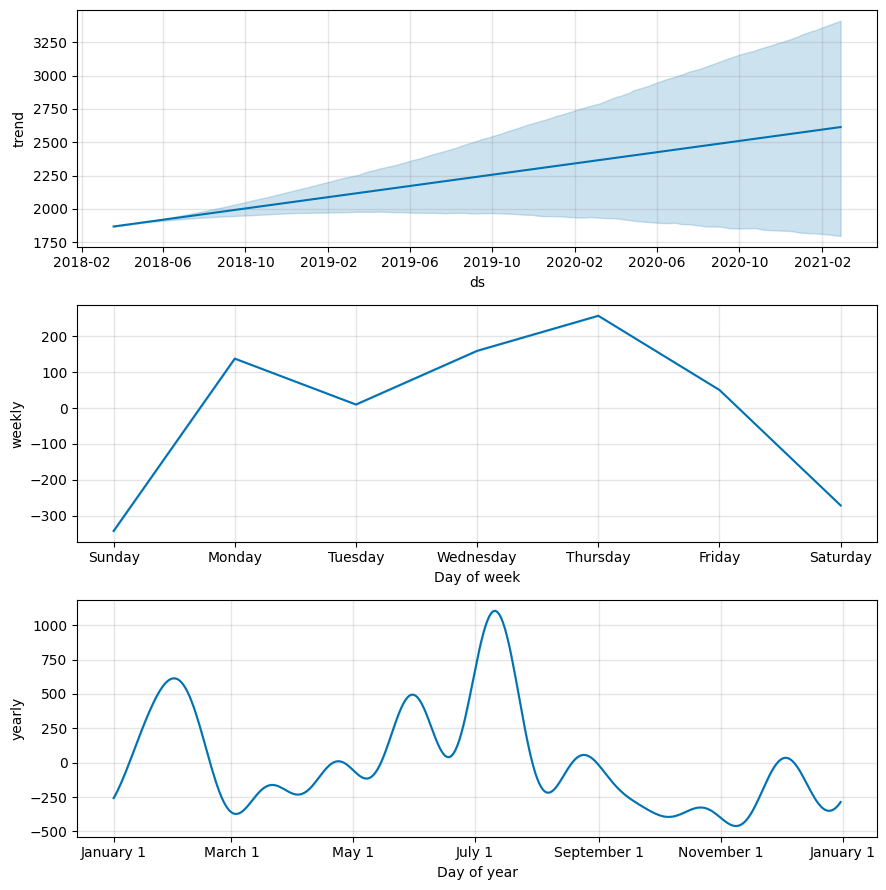

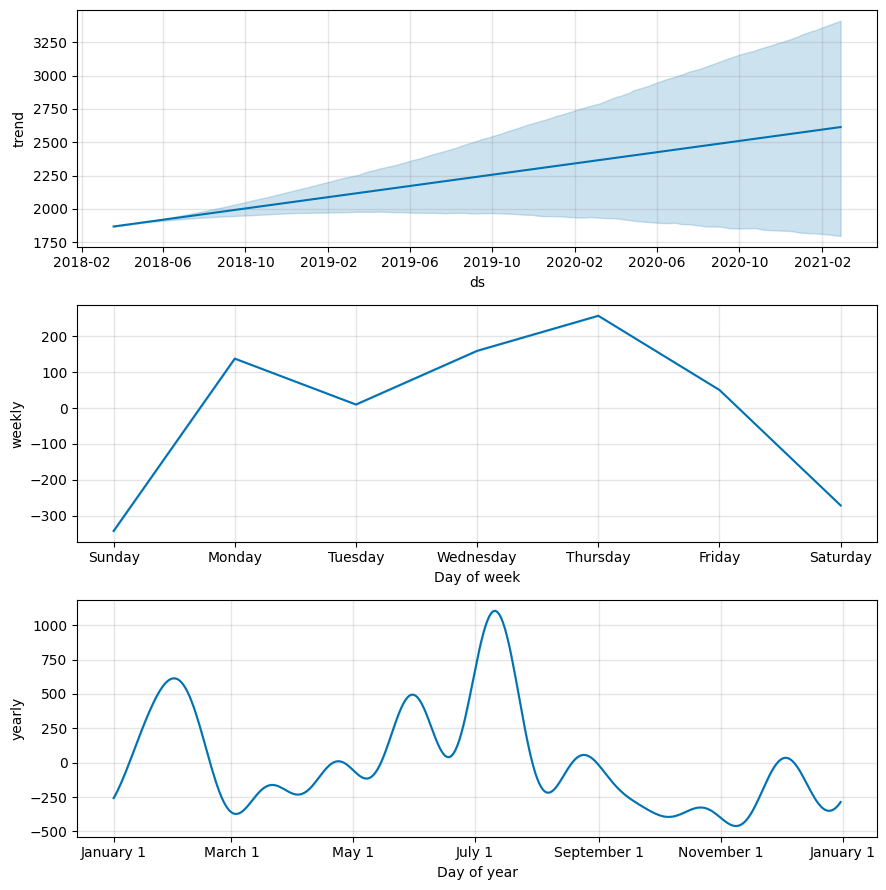

In [37]:
model.plot_components(new_forecast)

In [38]:
new_data = df2.drop('add2', axis=1)

In [39]:
new_data.sample(2)

,ds,add1,add3,y
1025,2013-06-22,17171.38205,144.024,1879.330
1759,2015-06-26,32495.53735,98.160,1007.715


In [40]:
train = new_data.iloc[:2757]
test  = new_data.iloc[2757:]

In [41]:
train_df = train.rename(columns = {'FullDate':'ds',
                                           'SysLoad':'add1','GasPrice':'add2',
                                           'ElecPrice':'y'})
test_df = test.rename(columns = {'FullDate':'ds',
                                           'SysLoad':'add1','GasPrice':'add2',
                                           'ElecPrice':'y'})

In [42]:
model3 = Prophet()
model3.add_regressor('add1')
model3.add_regressor('add3')
model3.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplpzxd83_/wo0rxvgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplpzxd83_/iw66rjyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27422', 'data', 'file=/tmp/tmplpzxd83_/wo0rxvgd.json', 'init=/tmp/tmplpzxd83_/iw66rjyy.json', 'output', 'file=/tmp/tmplpzxd83_/prophet_model20d81o99/prophet_model-20230401192123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [43]:
new_forecast2 = model3.predict(test_df)

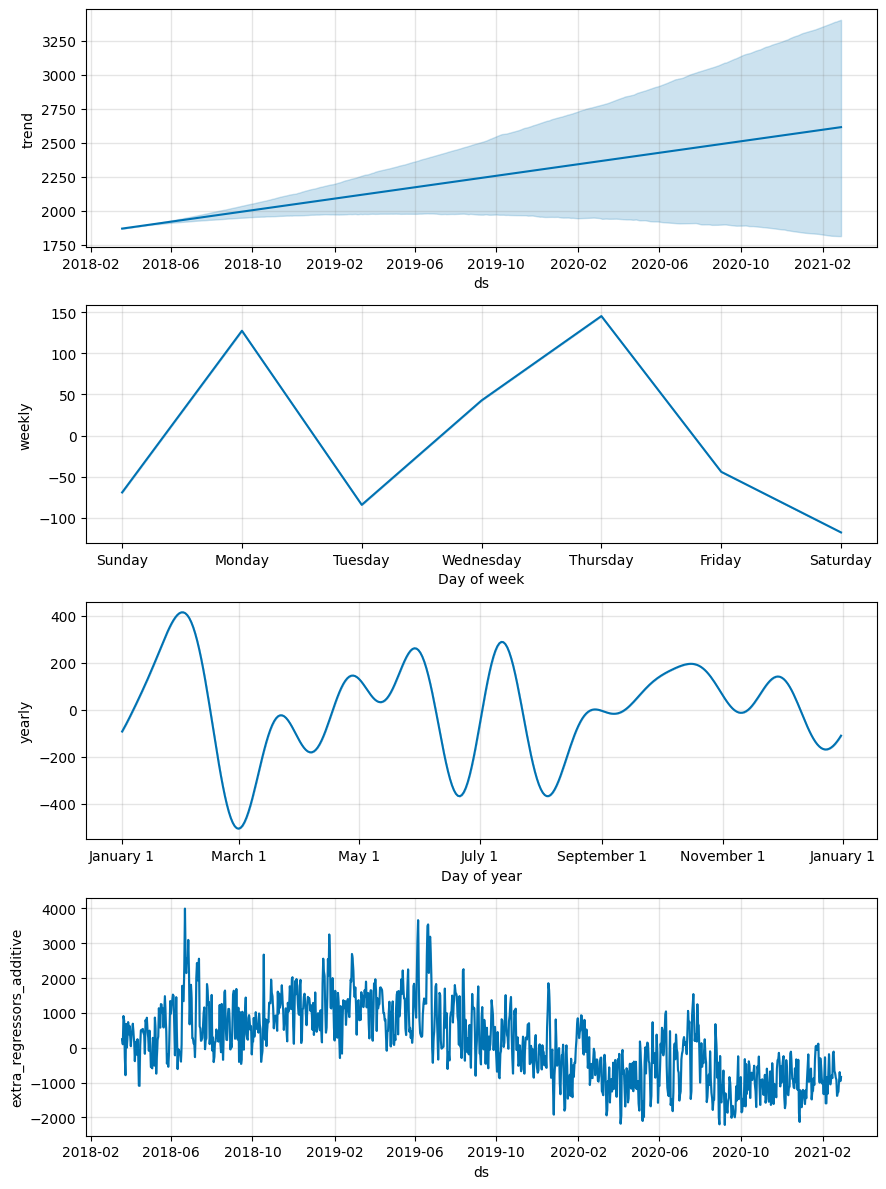

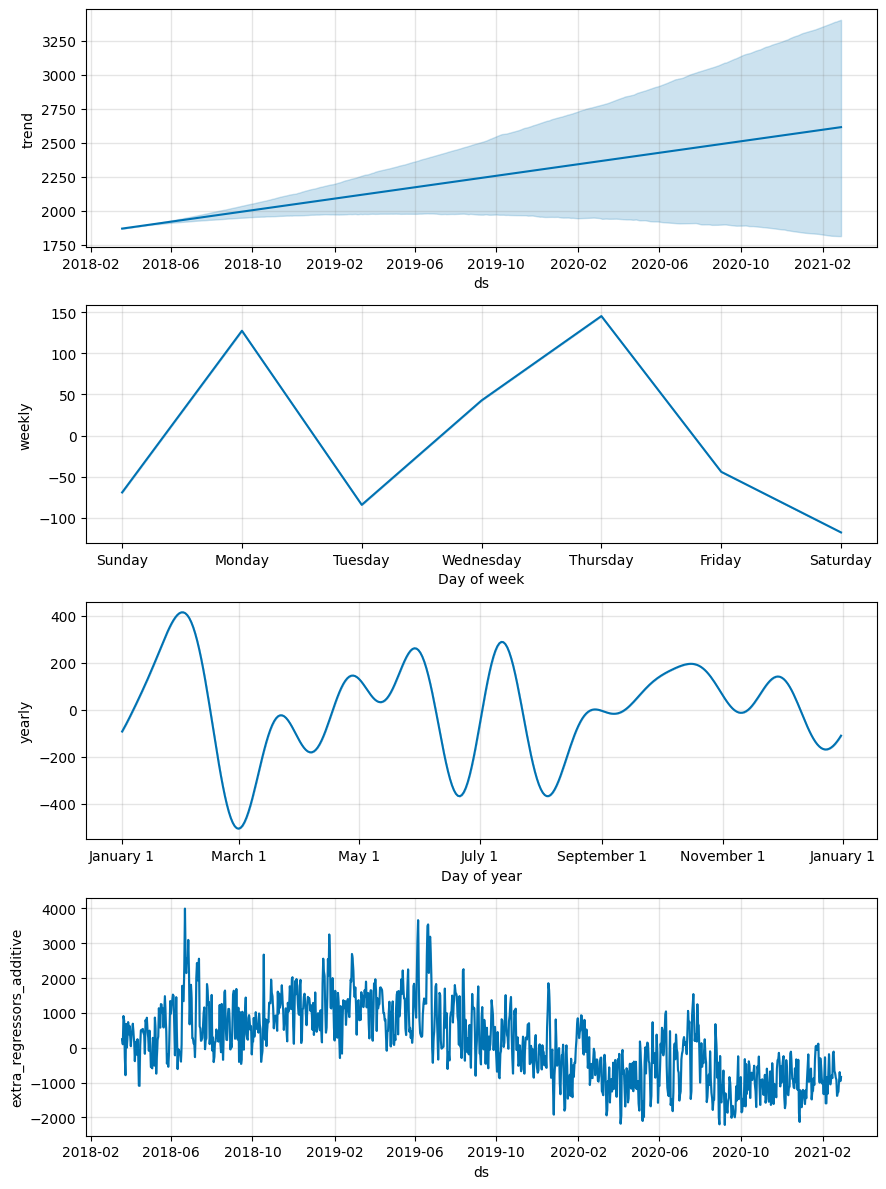

In [44]:
#Question: 19, what day of the daily seasonality has the highest value
model3.plot_components(new_forecast2)

In [45]:
#Question: 20, the mean absolute percentage error (MAPE) to 2 decimal places on the test set is:
MAPE = Metric(test['y'],new_forecast2['yhat'])
round(MAPE,2)

232.84